In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import polars as pl

# Load data as tensors and move to the correct device
playerStats = torch.tensor(np.load('../../finalDataSets/playerStats.npy')).float()
teamStats = torch.tensor(pl.read_csv('../../finalDataSets/team12Stats.csv').to_numpy()).float()
balltoball = torch.tensor(pl.read_csv('../../finalDataSets/balltoball.csv').to_numpy()).float()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

playerStats = playerStats.to(device)
teamStats = teamStats.to(device)
balltoball = balltoball.to(device)

# Shapes of the data
playerStats_shape = playerStats.shape
teamStats_shape = teamStats.shape
balltoball_shape = balltoball.shape
playerStats_shape,teamStats_shape,balltoball_shape

Using device: cuda


(torch.Size([1156, 22, 23]), torch.Size([1156, 24]), torch.Size([267455, 6]))

In [4]:
# Define the model
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        
        # RNN for balltoball data (2D input)
        self.lstm = nn.LSTM(input_size=balltoball_shape[1], hidden_size=64, num_layers=2, batch_first=True)
        self.rnn_fc = nn.Linear(64, 16)
        
        # CNN for playerStats data (3D input)
        self.conv1 = nn.Conv1d(in_channels=playerStats_shape[2], out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.cnn_fc = nn.Linear(64, 16)
        
        # ANN for teamStats data (2D input)
        self.fc1 = nn.Linear(teamStats_shape[1], 32)
        self.fc2 = nn.Linear(32, 16)
        
        # Final layers after concatenation
        self.fc_combined1 = nn.Linear(16 + 16 + 16, 64)
        self.fc_combined2 = nn.Linear(64, 32)
        self.fc_out = nn.Linear(32, 1)  # Binary classification
    
    def forward(self, balltoball, playerStats, teamStats):
        # RNN branch for 2D balltoball data
        balltoball = balltoball.unsqueeze(1)  # Adding batch dimension for LSTM
        _, (hn, _) = self.lstm(balltoball)
        rnn_out = F.relu(self.rnn_fc(hn[-1]))

        # CNN branch for playerStats data
        x = F.relu(self.conv1(playerStats.permute(0, 2, 1)))
        x = F.max_pool1d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.adaptive_avg_pool1d(x, 1).squeeze(2)
        cnn_out = F.relu(self.cnn_fc(x))

        # ANN branch for 2D teamStats data
        z = F.relu(self.fc1(teamStats))
        ann_out = F.relu(self.fc2(z))

        # Concatenate outputs
        combined = torch.cat((rnn_out, cnn_out, ann_out), dim=1)
        
        # Final fully connected layers
        x = F.relu(self.fc_combined1(combined))
        x = F.relu(self.fc_combined2(x))
        output = torch.sigmoid(self.fc_out(x))
        
        return output

# Instantiate the model and move it to the GPU
model = CombinedModel().to(device)

# Check the model structure
print(model)

# Example of running the model with random data on the GPU
batch_size = 32
balltoball_data = torch.randn(batch_size, balltoball_shape[1]).to(device)  # 2D
playerStats_data = torch.randn(batch_size, playerStats_shape[1], playerStats_shape[2]).to(device)  # 3D
teamStats_data = torch.randn(batch_size, teamStats_shape[1]).to(device)  # 2D

# Run the forward pass
output = model(balltoball_data, playerStats_data, teamStats_data)
print("Output shape:", output.shape)

CombinedModel(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (rnn_fc): Linear(in_features=64, out_features=16, bias=True)
  (conv1): Conv1d(23, 32, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (cnn_fc): Linear(in_features=64, out_features=16, bias=True)
  (fc1): Linear(in_features=24, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc_combined1): Linear(in_features=48, out_features=64, bias=True)
  (fc_combined2): Linear(in_features=64, out_features=32, bias=True)
  (fc_out): Linear(in_features=32, out_features=1, bias=True)
)
Output shape: torch.Size([32, 1])


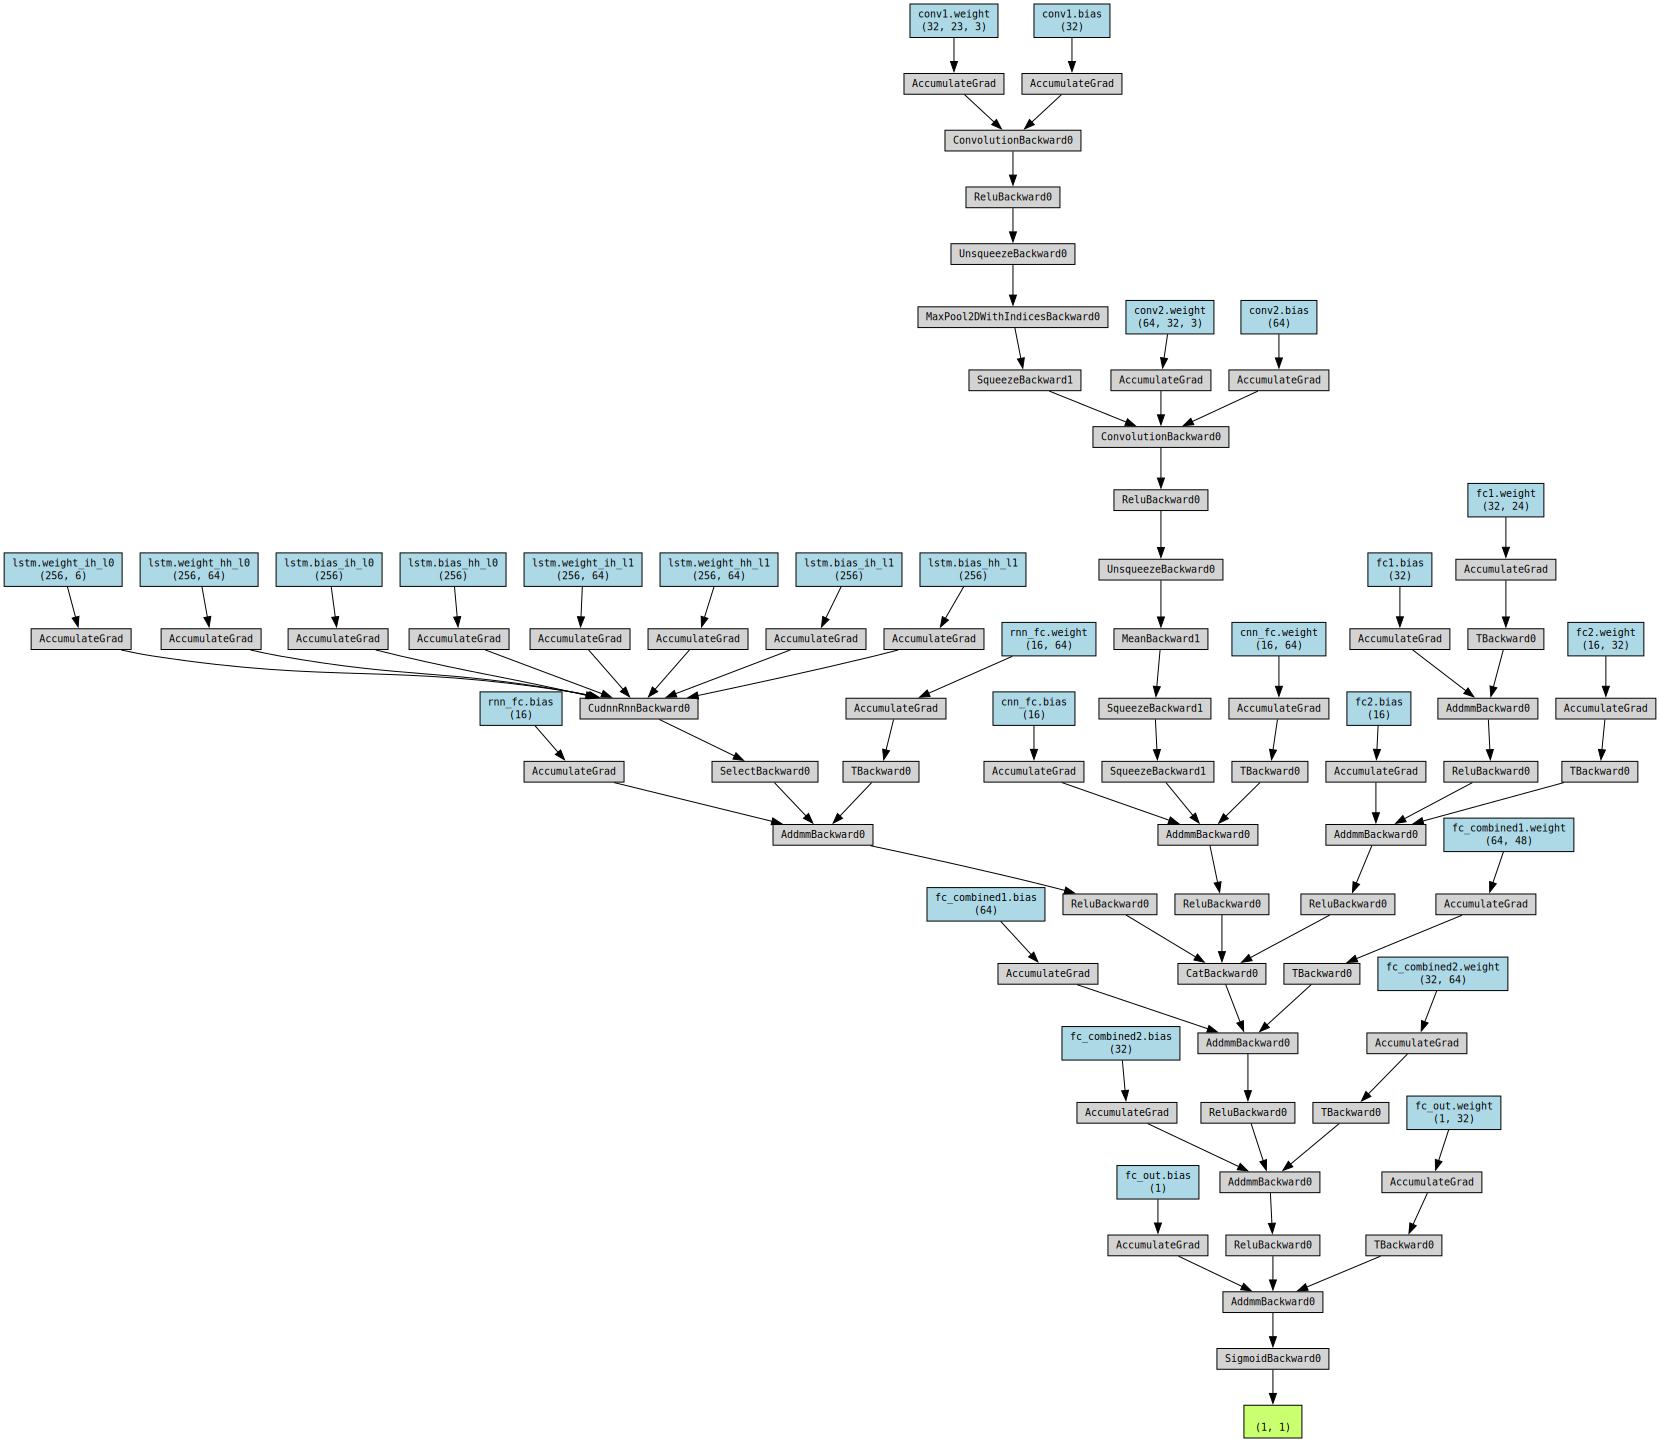

In [5]:
# plot model
from torchviz import make_dot
x = torch.rand(1, balltoball_shape[1]).to(device)
y = torch.rand(1, playerStats_shape[1], playerStats_shape[2]).to(device)
z = torch.rand(1, teamStats_shape[1]).to(device)
model = model.to(device)
make_dot(model(x, y, z), params=dict(model.named_parameters()))